# QABot with BERT

## Task description
- Extractive Question Answering
  - Input: Paragraph + Question
  - Output: Answer

## Import Packages

In [98]:
import json
import numpy as np
import random
import torch
from torch.utils.data import DataLoader, Dataset 
from torch.optim import AdamW
from transformers import BertForQuestionAnswering, BertTokenizerFast, get_cosine_schedule_with_warmup

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seed for reproducibility
def same_seeds(seed):
	  torch.manual_seed(seed)
	  if torch.cuda.is_available():
		    torch.cuda.manual_seed(seed)
		    torch.cuda.manual_seed_all(seed)
	  np.random.seed(seed)
	  random.seed(seed)
	  torch.backends.cudnn.benchmark = False
	  torch.backends.cudnn.deterministic = True
same_seeds(0)

In [99]:
# Change "fp16_training" to True to support automatic mixed precision training (fp16)
fp16_training = True

if fp16_training:
    # !pip install accelerate==0.2.0
    from accelerate import Accelerator
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    print(device)

# Documentation for the toolkit:  https://huggingface.co/docs/accelerate/

cuda


## Load Model and Tokenizer






In [100]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Read Data

- Training set: 87599 QA pairs
  - max tokenized question length: 61
  - max tokenized context length: 853
- Dev set: 34726  QA pairs
- Test set: try to generate via ChatGPT(to-do)


dataset structure
- title
- paragraphs
    - context
    - qas
      - answers
        - answer_start
        - test
      - question
      - id

In [101]:
def read_data(file):
    with open(file, 'rb') as reader:
        data = json.load(reader)
    contexts, questions, answers = [], [], []
    for group in data['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                # question = qa['question']
                # for answer in qa['answers']:
                #     contexts.append(context)
                #     questions.append(question)
                #     answers.append(answer)
                contexts.append(context)
                questions.append(qa['question'])
                answers.append(qa['answers'])
    return contexts, questions, answers

train_contexts, train_questions, train_answers = read_data("dataset/train-v1.1.json")
dev_contexts, dev_questions, dev_answers = read_data("dataset/dev-v1.1.json")

In [102]:
len(train_contexts)

87599

In [103]:
len(dev_contexts)

10570

In [104]:
max(len(answer) for answer in train_answers)

1

In [105]:
# distribution of number of answer per question in dev set
from collections import Counter
Counter(len(answer) for answer in dev_answers)

Counter({3: 8490, 5: 1147, 4: 759, 2: 136, 6: 35, 1: 3})

In [106]:
train_contexts[0]

'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.'

In [107]:
train_questions[0]

'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?'

In [108]:
train_answers[0:10]

[[{'answer_start': 515, 'text': 'Saint Bernadette Soubirous'}],
 [{'answer_start': 188, 'text': 'a copper statue of Christ'}],
 [{'answer_start': 279, 'text': 'the Main Building'}],
 [{'answer_start': 381, 'text': 'a Marian place of prayer and reflection'}],
 [{'answer_start': 92, 'text': 'a golden statue of the Virgin Mary'}],
 [{'answer_start': 248, 'text': 'September 1876'}],
 [{'answer_start': 441, 'text': 'twice'}],
 [{'answer_start': 598, 'text': 'The Observer'}],
 [{'answer_start': 126, 'text': 'three'}],
 [{'answer_start': 908, 'text': '1987'}]]

**mutiple answers to the same question in dev set, I guess it's for the accuracy of labeling**

In [109]:
dev_questions[:5]

['Which NFL team represented the AFC at Super Bowl 50?',
 'Which NFL team represented the NFC at Super Bowl 50?',
 'Where did Super Bowl 50 take place?',
 'Which NFL team won Super Bowl 50?',
 'What color was used to emphasize the 50th anniversary of the Super Bowl?']

In [110]:
dev_answers[:5]

[[{'answer_start': 177, 'text': 'Denver Broncos'},
  {'answer_start': 177, 'text': 'Denver Broncos'},
  {'answer_start': 177, 'text': 'Denver Broncos'}],
 [{'answer_start': 249, 'text': 'Carolina Panthers'},
  {'answer_start': 249, 'text': 'Carolina Panthers'},
  {'answer_start': 249, 'text': 'Carolina Panthers'}],
 [{'answer_start': 403, 'text': 'Santa Clara, California'},
  {'answer_start': 355, 'text': "Levi's Stadium"},
  {'answer_start': 355,
   'text': "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."}],
 [{'answer_start': 177, 'text': 'Denver Broncos'},
  {'answer_start': 177, 'text': 'Denver Broncos'},
  {'answer_start': 177, 'text': 'Denver Broncos'}],
 [{'answer_start': 488, 'text': 'gold'},
  {'answer_start': 488, 'text': 'gold'},
  {'answer_start': 521, 'text': 'gold'}]]

In [111]:
dev_questions[6:9]

['What day was the game played on?',
 'What is the AFC short for?',
 'What was the theme of Super Bowl 50?']

In [112]:
dev_answers[6:9]

[[{'answer_start': 334, 'text': 'February 7, 2016'},
  {'answer_start': 334, 'text': 'February 7'},
  {'answer_start': 334, 'text': 'February 7, 2016'}],
 [{'answer_start': 133, 'text': 'American Football Conference'},
  {'answer_start': 133, 'text': 'American Football Conference'},
  {'answer_start': 133, 'text': 'American Football Conference'}],
 [{'answer_start': 487, 'text': '"golden anniversary"'},
  {'answer_start': 521, 'text': 'gold-themed'},
  {'answer_start': 521, 'text': 'gold'}]]

In [113]:
dev_questions[10:15]

['What day was the Super Bowl played on?',
 'Who won Super Bowl 50?',
 'What venue did Super Bowl 50 take place in?',
 'What city did Super Bowl 50 take place in?',
 'If Roman numerals were used, what would Super Bowl 50 have been called?']

In [114]:
dev_answers[10:15]

[[{'answer_start': 334, 'text': 'February 7, 2016'},
  {'answer_start': 334, 'text': 'February 7'},
  {'answer_start': 334, 'text': 'February 7, 2016'}],
 [{'answer_start': 177, 'text': 'Denver Broncos'},
  {'answer_start': 177, 'text': 'Denver Broncos'},
  {'answer_start': 177, 'text': 'Denver Broncos'}],
 [{'answer_start': 355, 'text': "Levi's Stadium"},
  {'answer_start': 355, 'text': "Levi's Stadium"},
  {'answer_start': 355,
   'text': "Levi's Stadium in the San Francisco Bay Area at Santa Clara"}],
 [{'answer_start': 403, 'text': 'Santa Clara'},
  {'answer_start': 403, 'text': 'Santa Clara'},
  {'answer_start': 403, 'text': 'Santa Clara'}],
 [{'answer_start': 693, 'text': 'Super Bowl L'},
  {'answer_start': 704, 'text': 'L'},
  {'answer_start': 693, 'text': 'Super Bowl L'}]]

## Tokenize Data

In [115]:
# Tokenize questions and paragraphs separatelymixed_precision
# 「add_special_tokens」 is set to False since special tokens will be added when tokenized questions and paragraphs are combined in datset __getitem__

train_questions_tokenized = tokenizer([train_question for train_question in train_questions], add_special_tokens=False)
dev_questions_tokenized = tokenizer([dev_question for dev_question in dev_questions], add_special_tokens=False)

train_contexts_tokenized = tokenizer(train_contexts, add_special_tokens=False)
dev_contexts_tokenized = tokenizer(dev_contexts, add_special_tokens=False)


# tokenized sequences will be futher processed in datset __getitem__ before passing to model

Token indices sequence length is longer than the specified maximum sequence length for this model (718 > 512). Running this sequence through the model will result in indexing errors


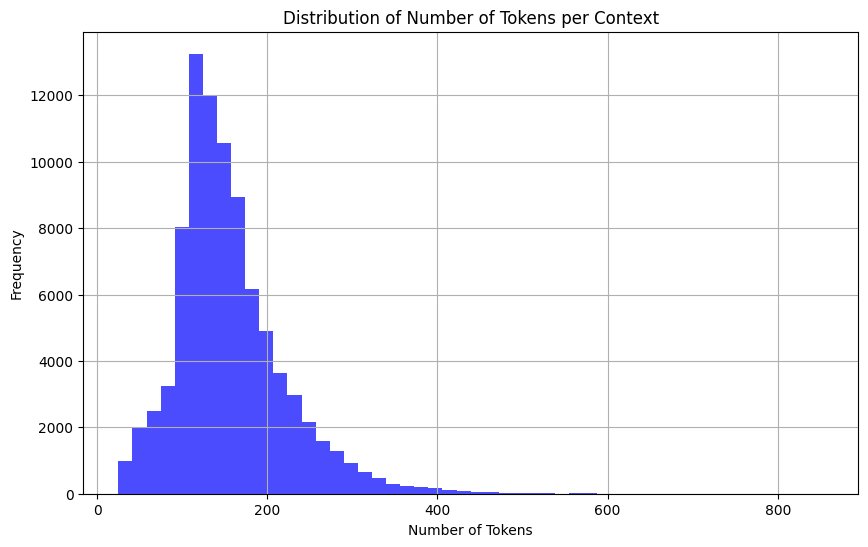

In [116]:
import matplotlib.pyplot as plt

num_tokens_per_context = [len(tokens) for tokens in train_contexts_tokenized['input_ids']]

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(num_tokens_per_context, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Number of Tokens per Context')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [117]:
len(train_questions_tokenized['input_ids'])

87599

In [118]:
len(train_answers)

87599

In [119]:
# max tokenized question length
max(len(train_questions_tokenized['input_ids'][i]) for i in range(len(train_questions_tokenized['input_ids'])))

61

In [120]:
# max tokenized question length
max(len(train_contexts_tokenized['input_ids'][i]) for i in range(len(train_contexts_tokenized['input_ids'])))

853

In [121]:
train_contexts_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [122]:
train_contexts_tokenized[0].ids

[6549,
 2135,
 1010,
 1996,
 2082,
 2038,
 1037,
 3234,
 2839,
 1012,
 10234,
 1996,
 2364,
 2311,
 1005,
 1055,
 2751,
 8514,
 2003,
 1037,
 3585,
 6231,
 1997,
 1996,
 6261,
 2984,
 1012,
 3202,
 1999,
 2392,
 1997,
 1996,
 2364,
 2311,
 1998,
 5307,
 2009,
 1010,
 2003,
 1037,
 6967,
 6231,
 1997,
 4828,
 2007,
 2608,
 2039,
 14995,
 6924,
 2007,
 1996,
 5722,
 1000,
 2310,
 3490,
 2618,
 4748,
 2033,
 18168,
 5267,
 1000,
 1012,
 2279,
 2000,
 1996,
 2364,
 2311,
 2003,
 1996,
 13546,
 1997,
 1996,
 6730,
 2540,
 1012,
 3202,
 2369,
 1996,
 13546,
 2003,
 1996,
 24665,
 23052,
 1010,
 1037,
 14042,
 2173,
 1997,
 7083,
 1998,
 9185,
 1012,
 2009,
 2003,
 1037,
 15059,
 1997,
 1996,
 24665,
 23052,
 2012,
 10223,
 26371,
 1010,
 2605,
 2073,
 1996,
 6261,
 2984,
 22353,
 2135,
 2596,
 2000,
 3002,
 16595,
 9648,
 4674,
 2061,
 12083,
 9711,
 2271,
 1999,
 8517,
 1012,
 2012,
 1996,
 2203,
 1997,
 1996,
 2364,
 3298,
 1006,
 1998,
 1999,
 1037,
 3622,
 2240,
 2008,
 8539,
 2083,
 101

In [123]:
train_questions_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [124]:
train_questions_tokenized[0].tokens

['to',
 'whom',
 'did',
 'the',
 'virgin',
 'mary',
 'allegedly',
 'appear',
 'in',
 '1858',
 'in',
 'lou',
 '##rdes',
 'france',
 '?']

## Dataset and Dataloader

In [125]:
class QA_Dataset(Dataset):
    doc_stride = 50
    
    def __init__(self, split, answers, questions, tokenized_questions, tokenized_contexts, random_training_window=True):
        self.split = split
        self.answers = answers
        self.questions = questions
        self.tokenized_questions = tokenized_questions
        self.tokenized_contexts = tokenized_contexts
        self.random_training_window = random_training_window
        self.max_question_len = 40
        self.max_context_len = 150 # maybe better to change it to 100, based on the distribution of num of tokens in the contexts

        # Input sequence length = [CLS] + question + [SEP] + context + [SEP]
        self.max_seq_len = 1 + self.max_question_len + 1 + self.max_context_len + 1

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        answer = self.answers[idx][0] # self.answers[idx] is a list, for training set, the length of the list is 1.
        question = self.questions[idx]
        tokenized_question = self.tokenized_questions[idx]
        tokenized_context = self.tokenized_contexts[idx]


        if self.split == "train":
            # Convert answer's start/end positions in context_text to start/end positions in tokenized_context
            answer_start = answer['answer_start']
            answer_len = len(answer['text'])
            answer_end = answer_start + answer_len - 1
            
            answer_start_token = tokenized_context.char_to_token(answer_start)
            answer_end_token = tokenized_context.char_to_token(answer_end)

            # A single window is obtained by slicing the portion of context containing the answer
            if self.random_training_window:
                context_start_min = max(0, answer_end_token - self.max_context_len + 1)
                context_start_max = max(0, min(answer_start_token, len(tokenized_context) - self.max_context_len))
                context_start = random.randint(context_start_min, context_start_max + 1)    
            else:
                mid = (answer_start_token + answer_end_token) // 2
                context_start = max(0, min(mid - self.max_context_len // 2, len(tokenized_context) - self.max_context_len))
                
            context_end = context_start + self.max_context_len

            # Slice question/context and add special tokens (101: CLS, 102: SEP)
            input_ids_question = [101] + tokenized_question.ids[:self.max_question_len] + [102]
            input_ids_context = tokenized_context.ids[context_start : context_end] + [102]

            # Convert answer's start/end positions in tokenized_context to start/end positions in the window
            answer_start_token += len(input_ids_question) - context_start
            answer_end_token += len(input_ids_question) - context_start

            # Pad sequence and obtain inputs to model
            input_ids, token_type_ids, attention_mask = self.padding(input_ids_question, input_ids_context)
            return torch.tensor(input_ids), torch.tensor(token_type_ids), torch.tensor(attention_mask), answer_start_token, answer_end_token

        # Validation/Testing
        else:
            input_ids_list, token_type_ids_list, attention_mask_list = [], [], []

            # context is split into several windows, each with start positions separated by step "doc_stride"
            for i in range(0, len(tokenized_context), self.doc_stride):

                # Slice question/context and add special tokens (101: CLS, 102: SEP)
                input_ids_question = [101] + tokenized_question.ids[:self.max_question_len] + [102]
                input_ids_context = tokenized_context.ids[i : i + self.max_context_len] + [102]

                # Pad sequence and obtain inputs to model
                input_ids, token_type_ids, attention_mask = self.padding(input_ids_question, input_ids_context)

                input_ids_list.append(input_ids)
                token_type_ids_list.append(token_type_ids)
                attention_mask_list.append(attention_mask)

            return torch.tensor(input_ids_list), torch.tensor(token_type_ids_list), torch.tensor(attention_mask_list)

    def padding(self, input_ids_question, input_ids_context):
        # Pad zeros if sequence length is shorter than max_seq_len
        padding_len = self.max_seq_len - len(input_ids_question) - len(input_ids_context)
        # Indices of input sequence tokens in the vocabulary
        input_ids = input_ids_question + input_ids_context + [0] * padding_len
        # Segment token indices to indicate first and second portions of the inputs. Indices are selected in [0, 1]
        token_type_ids = [0] * len(input_ids_question) + [1] * len(input_ids_context) + [0] * padding_len
        # Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]
        attention_mask = [1] * (len(input_ids_question) + len(input_ids_context)) + [0] * padding_len

        return input_ids, token_type_ids, attention_mask

train_set = QA_Dataset("train", train_answers, train_questions, train_questions_tokenized, train_contexts_tokenized, random_training_window=True)
dev_set = QA_Dataset("dev", dev_answers, dev_questions, dev_questions_tokenized, dev_contexts_tokenized)
# test_set = QA_Dataset("test", test_questions, test_questions_tokenized, test_contexts_tokenized)

train_batch_size = 16

# Note: Do NOT change batch size of dev_loader / test_loader !
# Although batch size=1, it is actually a batch consisting of several windows from the same QA pair
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, pin_memory=True)
dev_loader = DataLoader(dev_set, batch_size=1, shuffle=False, pin_memory=True)
# test_loader = DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=True)

In [143]:
data_iter = iter(dev_loader)

In [144]:
next(data_iter)

[tensor([[[  101,  2029,  5088,  2136,  3421,  1996, 10511,  2012,  3565,  4605,
            2753,  1029,   102,  3565,  4605,  2753,  2001,  2019,  2137,  2374,
            2208,  2000,  5646,  1996,  3410,  1997,  1996,  2120,  2374,  2223,
            1006,  5088,  1007,  2005,  1996,  2325,  2161,  1012,  1996,  2137,
            2374,  3034,  1006, 10511,  1007,  3410,  7573, 14169,  3249,  1996,
            2120,  2374,  3034,  1006, 22309,  1007,  3410,  3792, 12915,  2484,
            1516,  2184,  2000,  7796,  2037,  2353,  3565,  4605,  2516,  1012,
            1996,  2208,  2001,  2209,  2006,  2337,  1021,  1010,  2355,  1010,
            2012, 11902,  1005,  1055,  3346,  1999,  1996,  2624,  3799,  3016,
            2181,  2012,  4203, 10254,  1010,  2662,  1012,  2004,  2023,  2001,
            1996, 12951,  3565,  4605,  1010,  1996,  2223, 13155,  1996,  1000,
            3585,  5315,  1000,  2007,  2536,  2751,  1011, 11773, 11107,  1010,
            2004,  2092,  20

## Function for Evaluation

In [165]:
def evaluate_v1(data, output, split=None, question_id=None):

    answer = ''
    answer_start_idx = -1
    answer_end_idx = -1
    max_prob = float('-inf')
    num_of_windows = data[0].shape[1]

    for k in range(num_of_windows):
        # Obtain answer by choosing the most probable start position / end position
        start_prob, start_index = torch.max(output.start_logits[k], dim=0)
        end_prob, end_index = torch.max(output.end_logits[k], dim=0)
        
        token_type_id = data[1][0][k].detach().cpu().numpy()
        # [CLS] + [question] + [SEP] + [context] + [SEP]
        context_start = token_type_id.argmax()
        context_end = len(token_type_id) - 1 - token_type_id[::-1].argmax()
        
        if start_index > end_index or start_index < context_start or end_index > context_end :
            continue
            

        # Probability of answer is calculated as sum of start_prob and end_prob
        prob = start_prob + end_prob

        # Replace answer if calculated probability is larger than previous windows
        if prob > max_prob:
            max_prob = prob
            # Convert tokens to chars
            answer = tokenizer.decode(data[0][0][k][start_index : end_index + 1])
            answer_start_idx = start_index
            answer_end_idx = end_index
            
            origin_start = start_index - context_start + k * QA_Dataset.doc_stride 
            origin_end = end_index - context_start + k * QA_Dataset.doc_stride 
            
    # print(f"{answer_start_idx=}")
    # print(f"{answer_end_idx=}")
            
    # answer = answer.replace(' ','')

    if '[UNK]' in answer:
        # find the original subtext based on the start and end index, replace the answer with the subtext
        if split == 'dev':
            print(dev_answers[question_id])
            context_tokenized = dev_contexts_tokenized[question_id]
            raw_start = context_tokenized.token_to_chars(origin_start)[0]
            raw_end = context_tokenized.token_to_chars(origin_end)[1]
            answer = dev_contexts[question_id][raw_start:raw_end]
            print(answer)
        if split == 'test':
            context_tokenized = test_contexts_tokenized[question_id]
            raw_start = context_tokenized.token_to_chars(origin_start)[0]
            raw_end = context_tokenized.token_to_chars(origin_end)[1]
            answer = test_contexts[question_id][raw_start:raw_end]
    

    return answer

In [204]:
def evaluate_v2(data, output, split=None, question_id=None):

    answer_start_idx = origin_start = -1
    answer_end_idx = origin_end = -1
    max_prob = float('-inf')
    num_of_windows = data[0].shape[1]
    updated = False

    for k in range(num_of_windows):
        # Obtain answer by choosing the most probable start position / end position
        start_prob, start_index = torch.max(output.start_logits[k], dim=0)
        end_prob, end_index = torch.max(output.end_logits[k], dim=0)
        
        token_type_id = data[1][0][k].detach().cpu().numpy()
        # [CLS] + [question] + [SEP] + [context] + [SEP]
        context_start = token_type_id.argmax()
        context_end = len(token_type_id) - 1 - token_type_id[::-1].argmax()
        
        if start_index > end_index or start_index < context_start or end_index > context_end:
            continue

        # Probability of answer is calculated as sum of start_prob and end_prob
        prob = start_prob + end_prob

        # Replace answer if calculated probability is larger than previous windows
        if prob > max_prob:
            max_prob = prob
            answer_start_idx = start_index
            answer_end_idx = end_index
            updated = True
            origin_start = answer_start_idx - context_start + k * QA_Dataset.doc_stride 
            origin_end = answer_end_idx - context_start + k * QA_Dataset.doc_stride 
            
    # print(f"{answer_start_idx=}")
    # print(f"{answer_end_idx=}")
    if not updated:
        return ''

    if split == 'dev':
        # print(dev_answers[question_id])
        context_tokenized = dev_contexts_tokenized[question_id]
        raw_start = context_tokenized.token_to_chars(origin_start)[0]
        raw_end = context_tokenized.token_to_chars(origin_end)[1]
        answer = dev_contexts[question_id][raw_start:raw_end]
        # print(answer)
    if split == 'test':
        context_tokenized = test_contexts_tokenized[question_id]
        raw_start = context_tokenized.token_to_chars(origin_start)[0]
        raw_end = context_tokenized.token_to_chars(origin_end)[1]
        answer = test_contexts[question_id][raw_start:raw_end]
    

    return answer

## Training

In [206]:
num_epoch = 2
validation = True
logging_step = 100
learning_rate = 1e-4
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_step = len(train_loader) * num_epoch

linear_learning_rate_decay = False
schedule_with_warm_up = True

if linear_learning_rate_decay and schedule_with_warm_up:
    linear_learning_rate_decay = False

if schedule_with_warm_up:
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=total_step//10, num_training_steps=total_step)

if fp16_training:
    if schedule_with_warm_up:
        model, optimizer, train_loader, lr_scheduler = accelerator.prepare(model,
                                                                           optimizer, 
                                                                           train_loader,
                                                                           scheduler)
    else:
        model, optimizer, train_loader = accelerator.prepare(model, 
                                                             optimizer, 
                                                             train_loader)

model.train()

print("Start Training ...")

for epoch in range(num_epoch):
    step = 1
    train_loss = train_acc = 0

    for data in tqdm(train_loader):
        # Load all data into GPU
        data = [i.to(device) for i in data]

        # Model inputs: input_ids, token_type_ids, attention_mask, start_positions, end_positions (Note: only "input_ids" is mandatory)
        # Model outputs: start_logits, end_logits, loss (return when start_positions/end_positions are provided)
        output = model(input_ids=data[0], token_type_ids=data[1], attention_mask=data[2], start_positions=data[3], end_positions=data[4])

        # Choose the most probable start position / end position
        start_index = torch.argmax(output.start_logits, dim=1)
        end_index = torch.argmax(output.end_logits, dim=1)

        # Prediction is correct only if both start_index and end_index are correct
        train_acc += ((start_index == data[3]) & (end_index == data[4])).float().mean()
        train_loss += output.loss

        if fp16_training:
            accelerator.backward(output.loss)
        else:
            output.loss.backward()

        optimizer.step()
        
        if linear_learning_rate_decay:
            optimizer.param_groups[0]['lr'] -= learning_rate / total_step 
        if schedule_with_warm_up:
            scheduler.step()
            
        optimizer.zero_grad()
        step += 1


        # Print training loss and accuracy over past logging step
        if step % logging_step == 0:
            print(f"Epoch {epoch + 1} | Step {step} | loss = {train_loss.item() / logging_step:.3f}, acc = {train_acc / logging_step:.3f}")
            train_loss = train_acc = 0

    if validation:
        print("Evaluating Dev Set ...")
        model.eval()
        with torch.no_grad():
            dev_acc = 0
            for i, data in enumerate(tqdm(dev_loader)):
                output = model(input_ids=data[0].squeeze(dim=0).to(device), token_type_ids=data[1].squeeze(dim=0).to(device),
                       attention_mask=data[2].squeeze(dim=0).to(device))
                # prediction is correct if the output matches one of the answer in the answers list
                correct_answers = [answer['text'] for answer in dev_answers[i]]
                pred_answer = evaluate_v2(data, output, split='dev', question_id=i)
                dev_acc += pred_answer in correct_answers
                # if pred_answer not in correct_answers:
                #     print(f"{pred_answer=}")
                #     print(f"{correct_answers=}")
            print(f"Validation | Epoch {epoch + 1} | acc = {dev_acc / len(dev_loader):.3f}")
        model.train()

# Save a model and its configuration file to the directory 「saved_model」
# i.e. there are two files under the direcory 「saved_model」: 「pytorch_model.bin」 and 「config.json」
# Saved model can be re-loaded using 「model = BertForQuestionAnswering.from_pretrained("saved_model")」
print("Saving Model ...")
model_save_dir = "saved_model"
model.save_pretrained(model_save_dir)

Start Training ...


  0%|          | 0/5475 [00:00<?, ?it/s]

Epoch 1 | Step 100 | loss = 0.825, acc = 0.626
Epoch 1 | Step 200 | loss = 0.800, acc = 0.642
Epoch 1 | Step 300 | loss = 0.733, acc = 0.654
Epoch 1 | Step 400 | loss = 0.753, acc = 0.652
Epoch 1 | Step 500 | loss = 0.814, acc = 0.636
Epoch 1 | Step 600 | loss = 0.907, acc = 0.607
Epoch 1 | Step 700 | loss = 0.879, acc = 0.597
Epoch 1 | Step 800 | loss = 0.932, acc = 0.603
Epoch 1 | Step 900 | loss = 0.934, acc = 0.587
Epoch 1 | Step 1000 | loss = 0.962, acc = 0.599
Epoch 1 | Step 1100 | loss = 0.998, acc = 0.572
Epoch 1 | Step 1200 | loss = 1.064, acc = 0.548
Epoch 1 | Step 1300 | loss = 1.110, acc = 0.542
Epoch 1 | Step 1400 | loss = 1.156, acc = 0.553
Epoch 1 | Step 1500 | loss = 1.123, acc = 0.549
Epoch 1 | Step 1600 | loss = 1.161, acc = 0.518
Epoch 1 | Step 1700 | loss = 1.162, acc = 0.525
Epoch 1 | Step 1800 | loss = 1.148, acc = 0.529
Epoch 1 | Step 1900 | loss = 1.147, acc = 0.532
Epoch 1 | Step 2000 | loss = 1.180, acc = 0.510
Epoch 1 | Step 2100 | loss = 1.178, acc = 0.519
E

  0%|          | 0/10570 [00:00<?, ?it/s]

continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
continue
c

  0%|          | 0/5475 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Testing

In [ ]:
print("Evaluating Test Set ...")

results = []

model.eval()
with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader)):
        output = model(input_ids=data[0].squeeze(dim=0).to(device), token_type_ids=data[1].squeeze(dim=0).to(device),
                       attention_mask=data[2].squeeze(dim=0).to(device))
        result, start_idx, end_idx = evaluate(data, 
                                              output, 
                                              split='test', 
                                              question_id=i)
        # print(f"question {len(results)}, start:{start_idx}, end:{end_idx}" )
        results.append(result)

result_file = "results.csv"
with open(result_file, 'w') as f:
	  f.write("ID,Answer\n")
	  for i, test_question in enumerate(test_questions):
        # Replace commas in answers with empty strings (since csv is separated by comma)
        # Answers in kaggle are processed in the same way
		    f.write(f"{test_question['id']},{results[i].replace(',','')}\n")

print(f"Completed! Result is in {result_file}")